In [ ]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
import math
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
img_height = 512
img_width = 1024
batch_size = 8

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=15,
    zoom_range=(0.95, 0.95),
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last",
    dtype=tf.float32,
    
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255, dtype=tf.float32)

train_gen = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/drawings/wave/training',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)


test_gen = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/drawings/wave/testing/',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="rgb",
    class_mode="binary",
    shuffle=True,
    seed=123,
)



Found 72 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [ ]:
#https://tfhub.dev/google/imagenet/resnet_v1_50/classification/4 
#https://tfhub.dev/google/tf2-preview/inception_v3/classification/4

In [ ]:
url = "https://tfhub.dev/google/imagenet/resnet_v1_50/classification/4"

base_model = hub.KerasLayer(url, input_shape=(img_height, img_width, 3))
wave_model = keras.Sequential(
    [
        base_model,
        layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.Dropout(0.3),
        layers.Dense(1,  activation="sigmoid"),
    ]
)


In [ ]:
wave_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1001)              25612201  
_________________________________________________________________
dense (Dense)                (None, 128)               128256    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 25,748,778
Trainable params: 136,577
Non-trainable params: 25,612,201
______________________________________

In [ ]:
METRICS = [
    keras.metrics.BinaryAccuracy(name="accuracy"),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
    keras.metrics.AUC(name="auc")
]

In [ ]:


wave_model.compile(
    optimizer=keras.optimizers.Adam(lr=3e-4),
    loss=[keras.losses.BinaryCrossentropy(from_logits=False)],
    metrics=METRICS,
)

In [ ]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    #axs[0].set_title("Accuracy eval")
    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    #axs[1].set_title("Error eval")

    plt.show()


In [ ]:
cb = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30)]

history = wave_model.fit(
    train_gen,
    epochs=150,
    verbose=2,
    validation_data=test_gen,
    callbacks=cb
)

Epoch 1/150
9/9 - 63s - loss: 1.1051 - accuracy: 0.5556 - precision: 0.5500 - recall: 0.6111 - auc: 0.5718 - val_loss: 0.8738 - val_accuracy: 0.6667 - val_precision: 0.7778 - val_recall: 0.4667 - val_auc: 0.8289
Epoch 2/150
9/9 - 9s - loss: 1.0057 - accuracy: 0.5972 - precision: 0.5854 - recall: 0.6667 - auc: 0.6493 - val_loss: 0.7152 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.8667 - val_auc: 0.9289
Epoch 3/150
9/9 - 9s - loss: 0.8607 - accuracy: 0.7361 - precision: 0.7742 - recall: 0.6667 - auc: 0.7809 - val_loss: 0.6692 - val_accuracy: 0.8667 - val_precision: 0.9231 - val_recall: 0.8000 - val_auc: 0.9244
Epoch 4/150
9/9 - 9s - loss: 0.7143 - accuracy: 0.8333 - precision: 0.8333 - recall: 0.8333 - auc: 0.8954 - val_loss: 0.6261 - val_accuracy: 0.8333 - val_precision: 0.8125 - val_recall: 0.8667 - val_auc: 0.9467
Epoch 5/150
9/9 - 9s - loss: 0.6711 - accuracy: 0.8472 - precision: 0.8378 - recall: 0.8611 - auc: 0.9140 - val_loss: 0.6736 - val_accuracy: 0.8000 - val_p

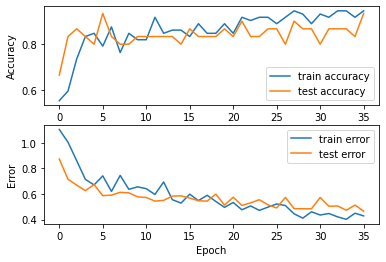

In [ ]:
plot_history(history)

In [ ]:

wave_model.evaluate(test_gen, verbose=2)


4/4 - 1s - loss: 0.4663 - accuracy: 0.9333 - precision: 0.9333 - recall: 0.9333 - auc: 0.9733


[0.46632084250450134,
 0.9333333373069763,
 0.9333333373069763,
 0.9333333373069763,
 0.9733333587646484]

In [ ]:
wave_model.evaluate(train_gen, verbose=2)

9/9 - 8s - loss: 0.4173 - accuracy: 0.9306 - precision: 1.0000 - recall: 0.8611 - auc: 0.9880


[0.4172763526439667,
 0.9305555820465088,
 1.0,
 0.8611111044883728,
 0.9880400896072388]

In [ ]:
#wave_model.save('/content/drive/MyDrive/saved_models/wave_saved_model/model1024')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/wave_saved_model/model1024/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/saved_models/wave_saved_model/model1024/assets
